In [1]:
!wget -nc https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/edgar_allan_poe.txt
!wget -nc https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt

--2025-03-03 20:42:24--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/edgar_allan_poe.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26622 (26K) [text/plain]
Saving to: ‘edgar_allan_poe.txt’

edgar_allan_poe.txt 100%[===================>]  26.00K  --.-KB/s    in 0.002s  

2025-03-03 20:42:24 (16.6 MB/s) - ‘edgar_allan_poe.txt’ saved [26622/26622]

--2025-03-03 20:42:24--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP re

In [10]:
# imports

from collections import defaultdict
import numpy as np
import math
import random
import string
from sklearn.model_selection import train_test_split

In [11]:
input_files = [
  'edgar_allan_poe.txt',
  'robert_frost.txt',
]

In [13]:
text = []
labels = []


for label, f in enumerate(input_files):
  print(f"{f} corresponds to label {label}")

  for line in open(f):
    line = line.rstrip().lower()
    if line:
      # remove punctuation
      line = line.translate(str.maketrans('', '', string.punctuation))

      text.append(line)
      labels.append(label)



edgar_allan_poe.txt corresponds to label 0
robert_frost.txt corresponds to label 1


In [14]:
train_text, test_text, Ytrain, Ytest = train_test_split(text, labels)
print(f"Training Size: {len(Ytrain)}, Test Size: {len(Ytest)}")

Training Size: 1615, Test Size: 539


In [16]:
word2index = {"<unk>" : 0}
index = 1

for line in train_text:
  words = line.split()
  for word in words:
    if word not in word2index:
      word2index[word] = index
      index += 1


In [21]:
train_text_int = []
test_text_int = []

for line in train_text:
  words = line.split()
  line_int = []
  for word in words:
    if word in word2index:
      line_int.append(word2index[word])
  train_text_int.append(line_int)


for line in test_text:
  words = line.split()
  line_int = []
  for word in words:
    if word in word2index:
      line_int.append(word2index[word])
  test_text_int.append(line_int)

print(train_text_int[:5])
print(test_text_int[:5])

[[1, 2, 3, 4, 5, 6, 7], [8, 2, 9, 10, 2, 11, 10, 2, 12, 10, 2, 13], [14, 15, 16, 17], [18, 19, 20, 21, 22, 23], [24, 10, 25, 26, 27, 28, 29, 9, 30, 31]]
[[444, 93], [1781, 237, 183, 25], [86, 2, 146], [81, 86, 2482, 44, 156], [680, 168, 40, 445, 86, 18, 339, 1235]]


In [46]:
V = len(word2index)

A0 = np.ones((V, V))
pi0 = np.ones(V)

A1 = np.ones((V, V))
pi1 = np.ones(V)

In [47]:
def count_transitions(text_as_int, A, pi):
  for line in text_as_int:
    prev_word_idx = None
    for word_idx in line:
      if prev_word_idx is None:
        pi[word_idx] += 1
      else:
        A[prev_word_idx, word_idx] += 1
      prev_word_idx = word_idx

count_transitions([s for s, y in zip(train_text_int, Ytrain) if y == 0], A0, pi0)
count_transitions([s for s, y in zip(train_text_int, Ytrain) if y == 1], A1, pi1)

In [48]:
# calculate now to prevent high precision errors
A0_log_rows = np.log(A0.sum(axis=1, keepdims=True)) # has add one smoothing baked in
A1_log_rows = np.log(A1.sum(axis=1, keepdims=True))

p0_count_log = np.log(pi0.sum())
p1_count_log = np.log(pi1.sum())

# get log editions
A0 = np.log(A0)
pi0 = np.log(pi0)

A1 = np.log(A1)
pi1 = np.log(pi1)

# remember log(m/b) = log(m) - log(b)

A0 -= A0_log_rows
A1 -= A1_log_rows

pi0 -= p0_count_log
pi1 -= p1_count_log

In this case we would like to know P(author|poem). This is the posterior. P(A) is the likelihood of the author, we can omit this if the probability of the authors are uniformly distributed. The likelihood is calculated as the probability a sequence occurs given it is a certain author. We classify by seeing for each markov model which sequence has the highest probability of being that particular author.

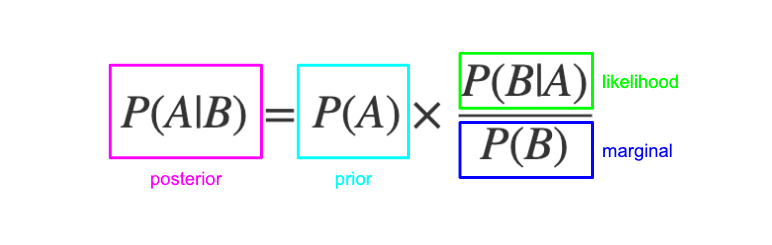

In [49]:
# compute priors
count0 = sum(y == 0 for y in Ytrain)
count1 = sum(y == 1 for y in Ytrain)
total = len(Ytrain)
p0 = count0 / total
p1 = count1 / total
logp0 = np.log(p0)
logp1 = np.log(p1)
p0, p1

(0.32941176470588235, 0.6705882352941176)

In [50]:
# build a classifier
class Classifier:
  def __init__(self, logAs, logpis, logpriors):
    self.logAs = logAs
    self.logpis = logpis
    self.logpriors = logpriors
    self.K = len(logpriors) # number of classes

  def _compute_log_likelihood(self, input_, class_):
    logA = self.logAs[class_]
    logpi = self.logpis[class_]

    last_idx = None
    logprob = 0
    for idx in input_:
      if last_idx is None:
        # it's the first token
        logprob += logpi[idx]
      else:
        logprob += logA[last_idx, idx]

      # update last_idx
      last_idx = idx

    return logprob

  def predict(self, inputs):
    predictions = np.zeros(len(inputs))
    for i, input_ in enumerate(inputs):
      posteriors = [self._compute_log_likelihood(input_, c) + self.logpriors[c] \
             for c in range(self.K)]
      pred = np.argmax(posteriors)
      predictions[i] = pred
    return predictions

In [70]:
# each array must be in order since classes are assumed to index these lists
clf = Classifier([A0, A1], [pi0, pi1], [logp0, logp1]) # we are using the posteriors

In [71]:
Ptrain = clf.predict(train_text_int)
print(f"Train acc: {np.mean(Ptrain == Ytrain)}")

Train acc: 0.9975232198142415


In [72]:
Ptest = clf.predict(test_text_int)
print(f"Test acc: {np.mean(Ptest == Ytest)}")

Test acc: 0.8070500927643784
